In [1]:
!pip install opendatasets --upgrade -q
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.9 MB/s eta 0:00:00


In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import opendatasets as od
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

In [3]:
dataset_url = 'https://www.kaggle.com/minbavel/cifar-100-images'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wali24
Your Kaggle Key: ··········


100%|██████████| 140M/140M [00:02<00:00, 55.1MB/s]


In [4]:
project_name="ds281-resnet9-cifar100-fine"

In [5]:
# I dowloaded the dataset using OpenDataset Library and by entering my Kaggle Key and Kaggle Username
# Let's look into the data directory
data_dir = './cifar-100-images/CIFAR100'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes[:10])
print(len(classes))

['TRAIN', 'TEST']
['sweet_pepper', 'camel', 'leopard', 'palm_tree', 'oak_tree', 'kangaroo', 'telephone', 'bowl', 'mouse', 'castle']
100


In [6]:
# Let's evaluate a single class say "man"
man_file=os.listdir(data_dir+"/TRAIN/man")
print("NO. of Training examples for Man:",len(man_file))
print(man_file[:5])

NO. of Training examples for Man: 500
['man_s_002051.png', 'adam_s_000645.png', 'man_s_001964.png', 'man_s_000128.png', 'man_s_000087.png']


In [7]:
# Let's see how many number of files/images are present in each classes
di={}
for i in classes:
    di[i]=len(os.listdir(data_dir+"/TRAIN/"+i))
print(di)

{'sweet_pepper': 500, 'camel': 500, 'leopard': 500, 'palm_tree': 500, 'oak_tree': 500, 'kangaroo': 500, 'telephone': 500, 'bowl': 500, 'mouse': 500, 'castle': 500, 'cockroach': 500, 'mushroom': 500, 'television': 500, 'bed': 500, 'shark': 500, 'turtle': 500, 'lobster': 500, 'pear': 500, 'apple': 500, 'tiger': 500, 'bridge': 500, 'skunk': 500, 'wolf': 500, 'forest': 500, 'dolphin': 500, 'tulip': 500, 'bottle': 500, 'pickup_truck': 500, 'man': 500, 'trout': 500, 'pine_tree': 500, 'elephant': 500, 'road': 500, 'poppy': 500, 'plain': 500, 'aquarium_fish': 500, 'whale': 500, 'bear': 500, 'house': 500, 'beaver': 500, 'chimpanzee': 500, 'tractor': 500, 'woman': 500, 'dinosaur': 500, 'orange': 500, 'willow_tree': 500, 'tank': 500, 'bee': 500, 'bicycle': 500, 'wardrobe': 500, 'squirrel': 500, 'lizard': 500, 'mountain': 500, 'beetle': 500, 'porcupine': 500, 'streetcar': 500, 'skyscraper': 500, 'train': 500, 'maple_tree': 500, 'cup': 500, 'sea': 500, 'girl': 500, 'rocket': 500, 'lamp': 500, 'keyb

In [8]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/TRAIN', tt.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.5071, 0.4865, 0.4409]), tensor([0.2009, 0.1984, 0.2023]))

In [9]:
# Data transforms (normalization & data augmentation)

stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
                        ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])

In [10]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(data_dir+'/TEST', valid_tfms)

In [11]:
# Let's use batch size
batch_size = 400

In [12]:

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

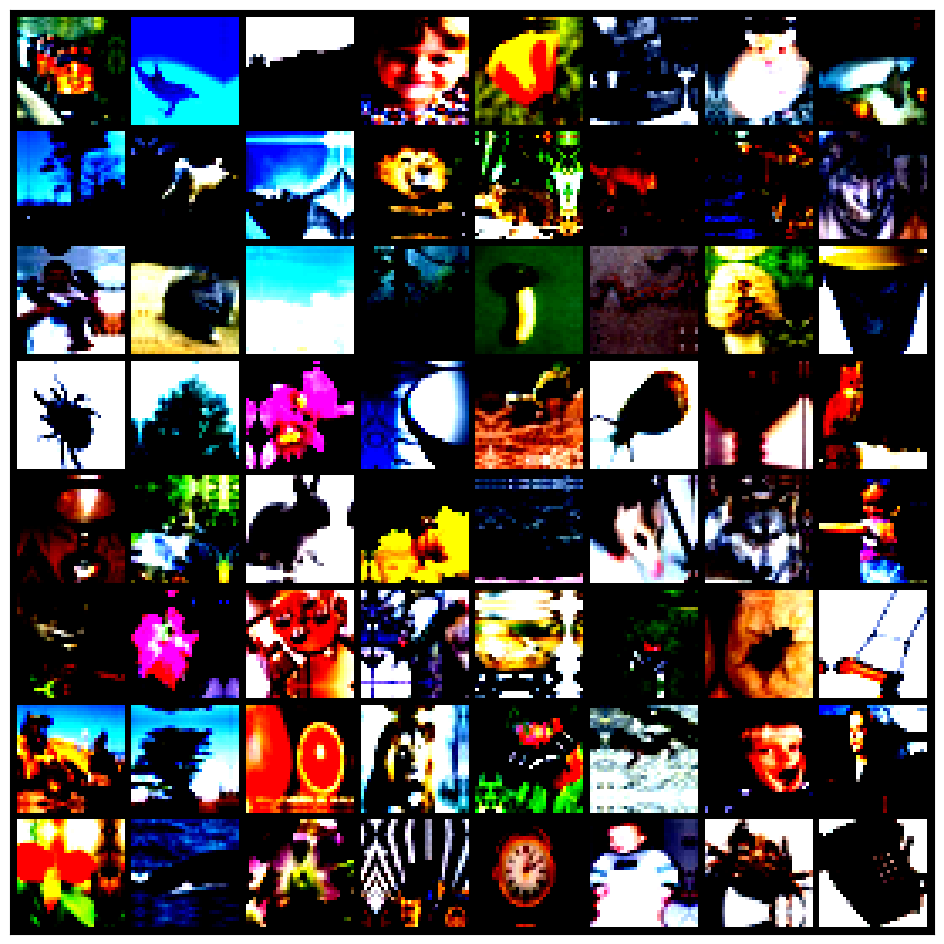

In [14]:
show_batch(train_dl);

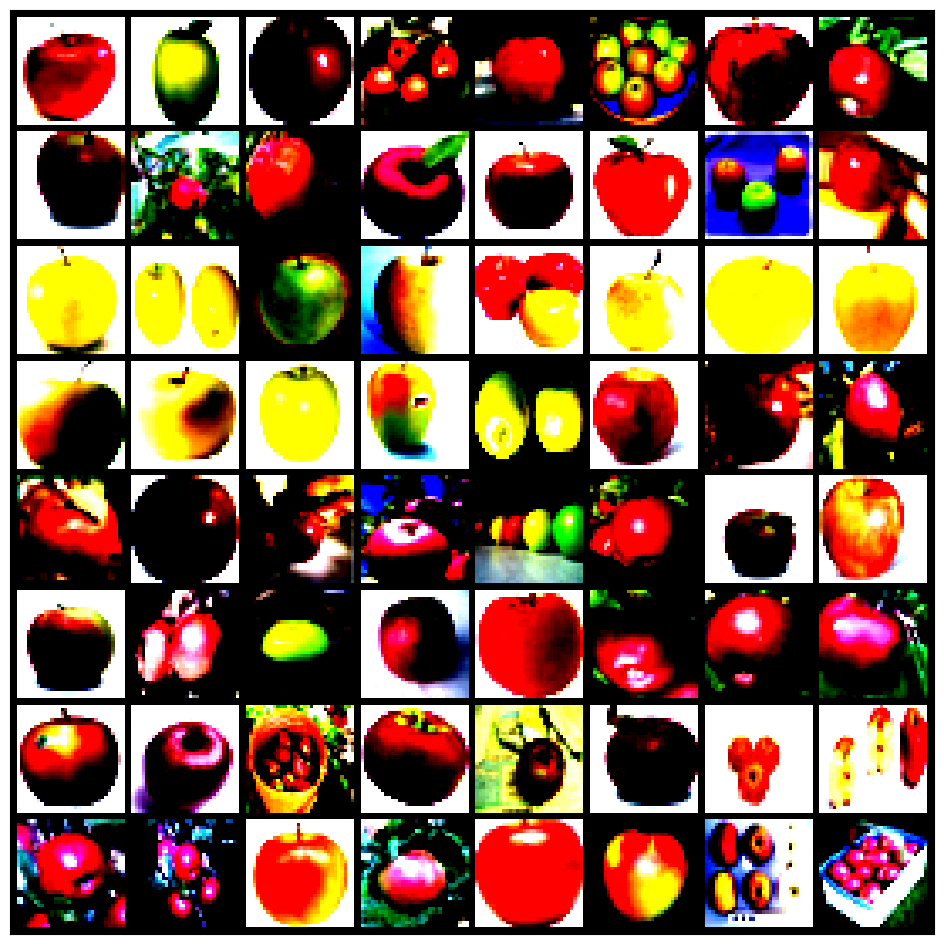

In [15]:
show_batch(valid_dl);

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
# Transfering data to the device in use (In our case GPU)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) # 3 x 32 x 32 -> 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 64 x 32 x 32 -> 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16 -> 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 256 x 8 x 8 -> 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4 -> 512 x 4 x 4
        self.conv5 = conv_block(512, 1028, pool=True) # 512 x 4 x 4 -> 1028 x 2 x 2
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  # 1028 x 2 x 2 -> 1028 x 2 x 2
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, num_classes)) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [21]:
model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.605812072753906, 'val_acc': 0.010096153244376183}]

In [24]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay =1e-4
opt_func = torch.optim.Adam

In [25]:
#model.freeze()

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 3.7813, val_loss: 4.1809, val_acc: 0.1575
Epoch [1], last_lr: 0.00759, train_loss: 3.1015, val_loss: 3.0855, val_acc: 0.2603
Epoch [2], last_lr: 0.01000, train_loss: 2.3758, val_loss: 2.5361, val_acc: 0.3480
Epoch [3], last_lr: 0.00950, train_loss: 1.9293, val_loss: 8.4205, val_acc: 0.1665
Epoch [4], last_lr: 0.00812, train_loss: 1.7369, val_loss: 1.9551, val_acc: 0.4784
Epoch [5], last_lr: 0.00611, train_loss: 1.4286, val_loss: 1.7092, val_acc: 0.5363
Epoch [6], last_lr: 0.00389, train_loss: 1.2079, val_loss: 1.4497, val_acc: 0.6004
Epoch [7], last_lr: 0.00188, train_loss: 0.9544, val_loss: 1.2356, val_acc: 0.6498
Epoch [8], last_lr: 0.00050, train_loss: 0.7027, val_loss: 1.0349, val_acc: 0.7025
Epoch [9], last_lr: 0.00000, train_loss: 0.5359, val_loss: 0.9942, val_acc: 0.7143
CPU times: user 32.7 s, sys: 4.67 s, total: 37.4 s
Wall time: 4min 12s


In [27]:
#model.unfreeze()

In [28]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00028, train_loss: 0.5034, val_loss: 1.0014, val_acc: 0.7121
Epoch [1], last_lr: 0.00076, train_loss: 0.5216, val_loss: 1.1008, val_acc: 0.6913
Epoch [2], last_lr: 0.00100, train_loss: 0.5517, val_loss: 1.1809, val_acc: 0.6747
Epoch [3], last_lr: 0.00095, train_loss: 0.5180, val_loss: 1.2316, val_acc: 0.6650
Epoch [4], last_lr: 0.00081, train_loss: 0.4369, val_loss: 1.1540, val_acc: 0.6829
Epoch [5], last_lr: 0.00061, train_loss: 0.3343, val_loss: 1.1081, val_acc: 0.6985
Epoch [6], last_lr: 0.00039, train_loss: 0.2452, val_loss: 1.0728, val_acc: 0.7119
Epoch [7], last_lr: 0.00019, train_loss: 0.1756, val_loss: 1.0404, val_acc: 0.7242
Epoch [8], last_lr: 0.00005, train_loss: 0.1329, val_loss: 1.0277, val_acc: 0.7268
Epoch [9], last_lr: 0.00000, train_loss: 0.1170, val_loss: 1.0251, val_acc: 0.7285
CPU times: user 32.6 s, sys: 4.55 s, total: 37.2 s
Wall time: 4min 12s


In [29]:
%%time
history += fit_one_cycle(5, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00008, train_loss: 0.1154, val_loss: 1.0267, val_acc: 0.7284
Epoch [1], last_lr: 0.00010, train_loss: 0.1132, val_loss: 1.0502, val_acc: 0.7262
Epoch [2], last_lr: 0.00006, train_loss: 0.1021, val_loss: 1.0375, val_acc: 0.7303
Epoch [3], last_lr: 0.00002, train_loss: 0.0926, val_loss: 1.0429, val_acc: 0.7280
Epoch [4], last_lr: 0.00000, train_loss: 0.0865, val_loss: 1.0404, val_acc: 0.7287
CPU times: user 16.3 s, sys: 2.28 s, total: 18.6 s
Wall time: 2min 7s


In [30]:
%%time
history += fit_one_cycle(5, 0.00001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.0862, val_loss: 1.0407, val_acc: 0.7283
Epoch [1], last_lr: 0.00001, train_loss: 0.0845, val_loss: 1.0417, val_acc: 0.7289
Epoch [2], last_lr: 0.00001, train_loss: 0.0844, val_loss: 1.0414, val_acc: 0.7302
Epoch [3], last_lr: 0.00000, train_loss: 0.0834, val_loss: 1.0407, val_acc: 0.7289
Epoch [4], last_lr: 0.00000, train_loss: 0.0808, val_loss: 1.0403, val_acc: 0.7302
CPU times: user 16.5 s, sys: 2.34 s, total: 18.9 s
Wall time: 2min 7s


In [31]:
%%time
history += fit_one_cycle(10, 0.0001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 0.0812, val_loss: 1.0438, val_acc: 0.7298
Epoch [1], last_lr: 0.00008, train_loss: 0.0825, val_loss: 1.0584, val_acc: 0.7262
Epoch [2], last_lr: 0.00010, train_loss: 0.0823, val_loss: 1.0708, val_acc: 0.7266
Epoch [3], last_lr: 0.00010, train_loss: 0.0754, val_loss: 1.0676, val_acc: 0.7296
Epoch [4], last_lr: 0.00008, train_loss: 0.0680, val_loss: 1.0734, val_acc: 0.7272
Epoch [5], last_lr: 0.00006, train_loss: 0.0601, val_loss: 1.0705, val_acc: 0.7307
Epoch [6], last_lr: 0.00004, train_loss: 0.0548, val_loss: 1.0796, val_acc: 0.7325
Epoch [7], last_lr: 0.00002, train_loss: 0.0529, val_loss: 1.0770, val_acc: 0.7307
Epoch [8], last_lr: 0.00000, train_loss: 0.0489, val_loss: 1.0774, val_acc: 0.7322
Epoch [9], last_lr: 0.00000, train_loss: 0.0481, val_loss: 1.0776, val_acc: 0.7310
CPU times: user 32.7 s, sys: 4.57 s, total: 37.2 s
Wall time: 4min 16s


In [32]:
train_time='00:22:00'

In [33]:
# Plotted the accuracy Graph
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

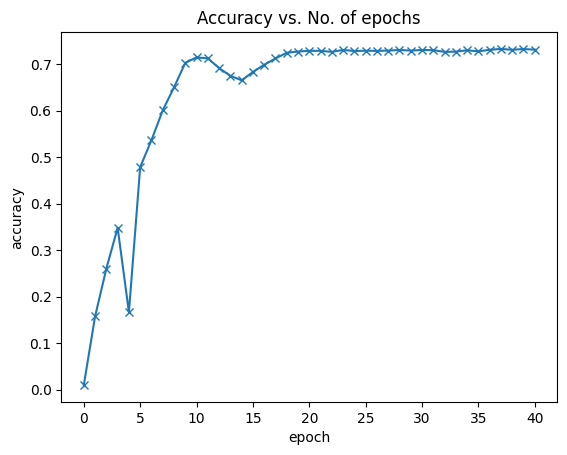

In [34]:
plot_accuracies(history)

In [35]:
# Training and Validation loss graph
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

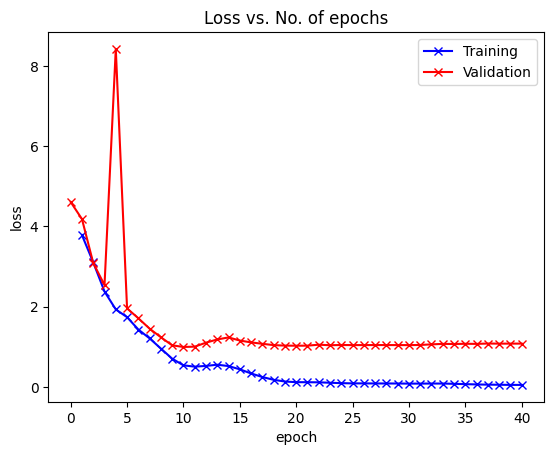

In [36]:
plot_losses(history)

In [37]:
# Learning Rate Graph
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

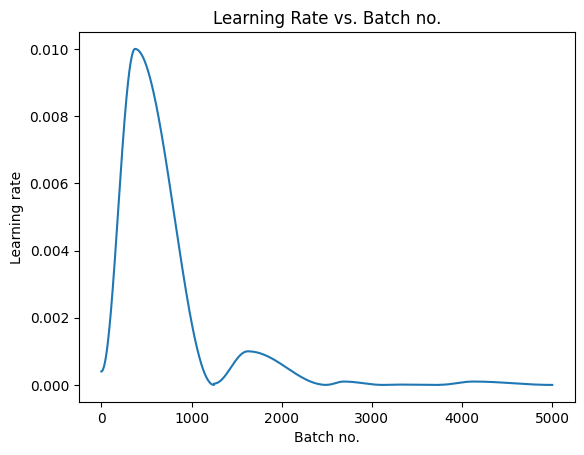

In [38]:
plot_lrs(history)

In [39]:
from torchvision.transforms import ToTensor
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)
                        ])
test_dataset = ImageFolder(data_dir+'/TEST', test_tfms)

In [40]:
dataset = ImageFolder(data_dir+'/TRAIN', transform=ToTensor())

In [41]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: bed , Predicted: bed


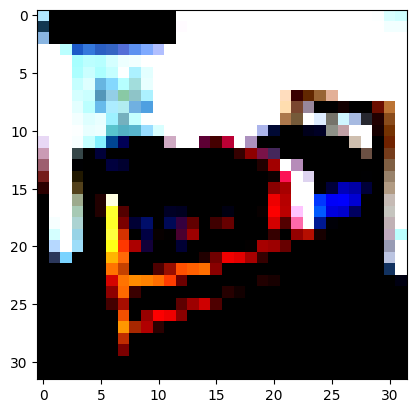

In [42]:

img, label = test_dataset[550]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: apple , Predicted: apple


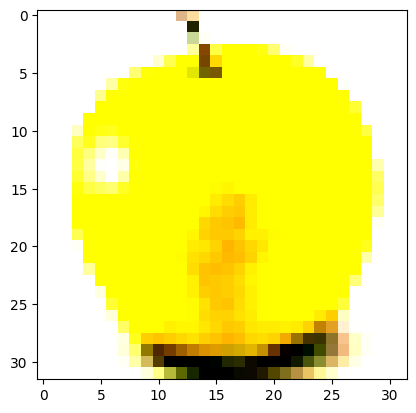

In [43]:
img, label = test_dataset[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: aquarium_fish , Predicted: aquarium_fish


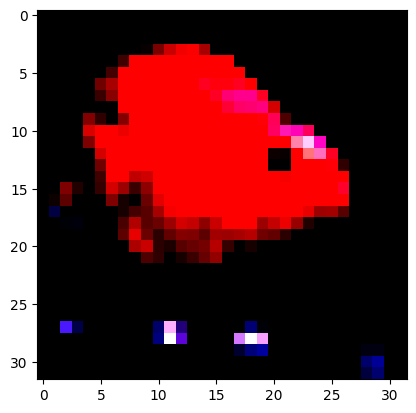

In [44]:

img, label = test_dataset[117]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: baby , Predicted: baby


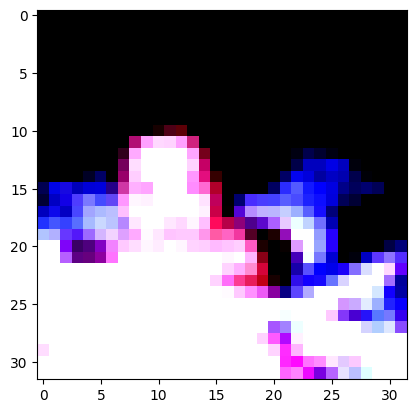

In [45]:

img, label = test_dataset[210]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: bed , Predicted: streetcar


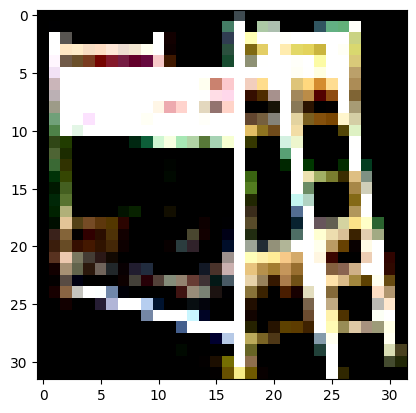

In [46]:
img, label = test_dataset[589]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [47]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.0776175260543823, 'val_acc': 0.7309615612030029}

In [62]:
PATH = 'ds281-resnet9-cifar100-fine.pth'

torch.save(model.state_dict(), PATH)

In [63]:
model2 = to_device(ResNet9(3, 100), device)

In [64]:
model2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [65]:
evaluate(model2, test_loader)

{'val_loss': 1.0776175260543823, 'val_acc': 0.7309615612030029}

In [100]:
dataset_test_dict = {'image':[], 'actual_label':[], 'predicted_label':[]}
for img, actual_label in test_dataset:
  dataset_test_dict['image'].append(img)
  dataset_test_dict['actual_label'].append(actual_label)
  dataset_test_dict['predicted_label'].append(dataset.classes.index(predict_image(img, model)))

In [ ]:
# Store the Predictions in a Data Frame
dataset_test_results_df = pd.DataFrame (dataset_test_dict, columns = ['image', 'actual_label','predicted_label'])
# Extract the Actual and Predicted Labels and convert into tensors
y_test_act_arr = torch.tensor(dataset_test_results_df[['actual_label']].values.flatten())
y_test_pred_arr = torch.tensor(dataset_test_results_df[['predicted_label']].values.flatten())

In [122]:
mcf1s = MulticlassF1Score(num_classes=100, average='macro')
f1score = mcf1s(y_test_pred_arr, y_test_act_arr)
mca = MulticlassAccuracy(num_classes=100, average='macro')
accuracy = mca(y_test_pred_arr, y_test_act_arr)
mcp = MulticlassPrecision(num_classes=100, average='macro')
precision = mcp(y_test_pred_arr, y_test_act_arr)
mcr = MulticlassRecall(num_classes=100, average='macro')
recall = mcr(y_test_pred_arr, y_test_act_arr)
metric = MulticlassConfusionMatrix(num_classes=100)
cm = metric(y_test_pred_arr, y_test_act_arr)
print('F1 score = %.3f,' % (f1score*100), 'Accuracy = %.3f,' % (accuracy*100), 'Precision = %.3f,' % (precision*100), 'Recall = %.3f ' % (recall*100))

F1 score = 73.326, Accuracy = 73.320, Precision = 73.562, Recall = 73.320 


In [125]:
def plot_conf(y_test_act_arr, y_test_pred_arr, label : str = "", figsize=(15,15)) :
    cm = confusion_matrix(y_test_act_arr, y_test_pred_arr)
    fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    fig.suptitle("confusion matrix %s"%label)
    f = sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

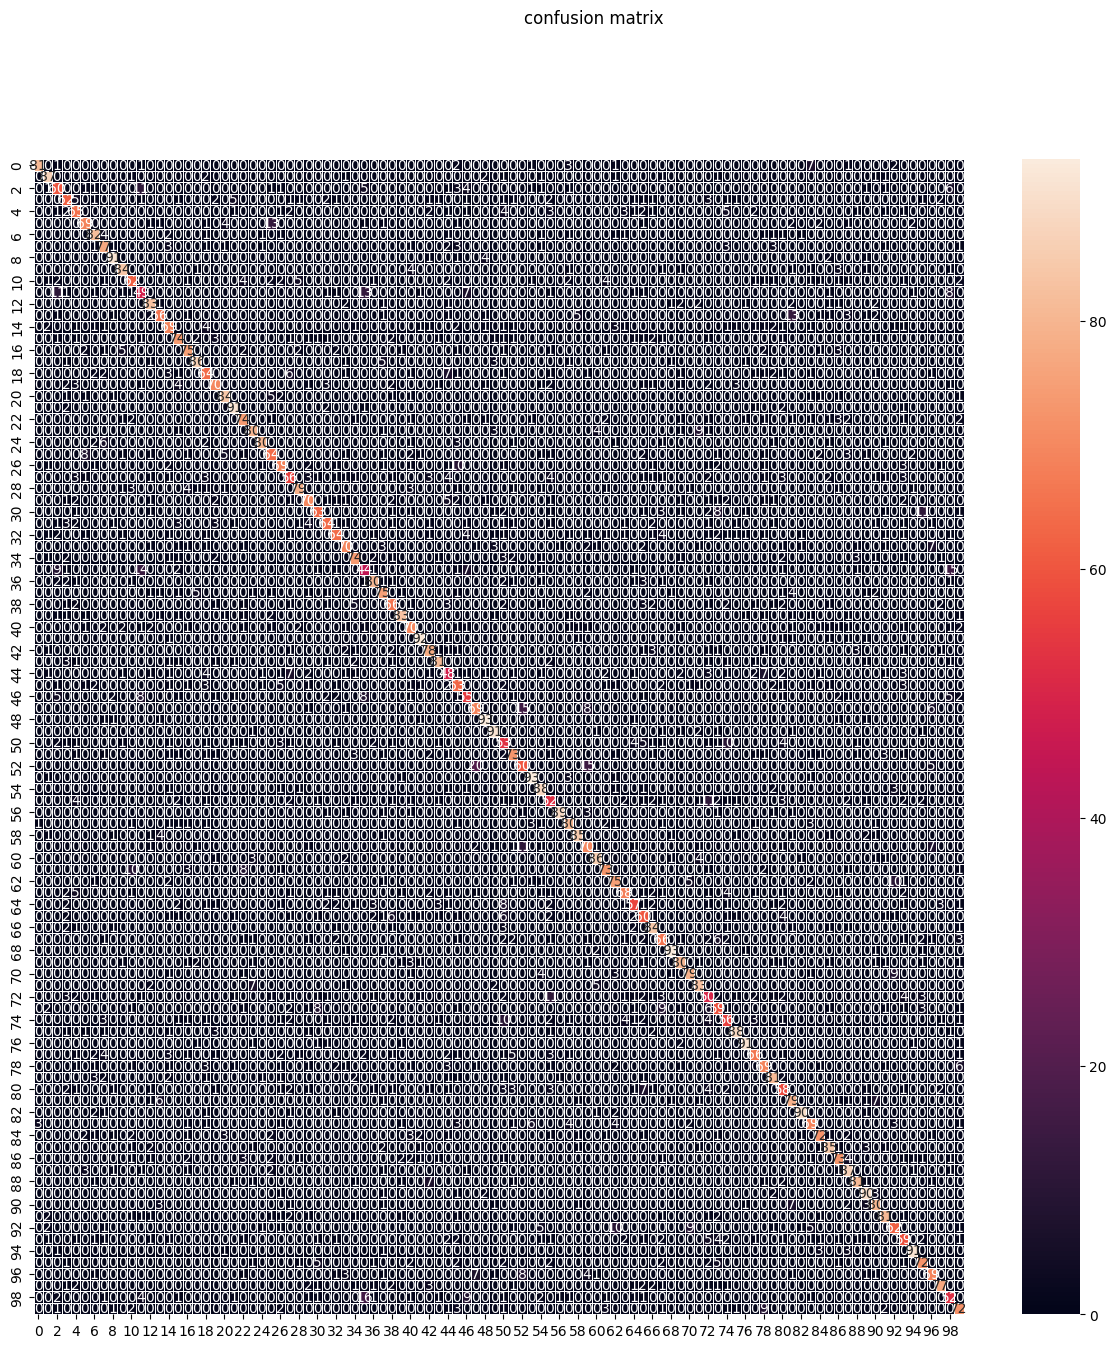

In [126]:
plot_conf(y_test_act_arr, y_test_pred_arr)